In [80]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler

import tqdm.notebook as tq
import warnings
warnings.filterwarnings('ignore')

import utils_cl
%matplotlib notebook
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
full_df = pd.read_csv("dataset/normalized_data.csv")
full_df.columns = ['timestamp','import_kwh','meter_id','is_fraud','date','import_kwh_shift1','consumption']
full_df.drop(['import_kwh', 'import_kwh_shift1'], axis=1, inplace = True)
full_df['timestamp'] = pd.to_datetime(full_df.timestamp)
full_df.dropna(inplace=True)

In [82]:
df = full_df
df['date'] = pd.to_datetime(df.date)
df.set_index('timestamp', inplace=True)

count    1818.000000
mean        1.908295
std         1.016886
min         0.168840
25%         1.122515
50%         1.721906
75%         2.494863
max         6.979871
Name: consumption, dtype: float64


<IPython.core.display.Javascript object>


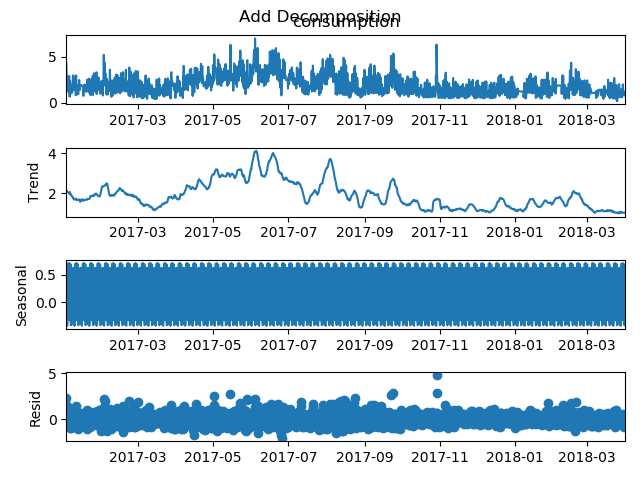

Text(0.5, 0.98, 'Add Decomposition')

In [83]:
# Test 1 sample fraud
sample_fr = df[df.meter_id == 'PP01000103454001']
print(sample_fr['consumption'].describe())
y = sample_fr['consumption']
x = sample_fr.index
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(sample_fr['consumption'], model = 'additive', extrapolate_trend='freq')
result_add.plot().suptitle('Add Decomposition')

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

list_mdd = df.meter_id.unique()
df2 = pd.DataFrame()
fault_mdd = []
for mdd in tq.tqdm(list_mdd) :
    sample_fr = df[df.meter_id == mdd]
    try :
        result_add = seasonal_decompose(sample_fr['consumption'], model = 'additive', extrapolate_trend='freq')
    except :
        fault_mdd.append(mdd)
        continue
    sample_fr['deseasonal'] = result_add.resid
    sample_fr.drop(['consumption'], axis = 1, inplace = True)
    df2 = pd.concat([df2, sample_fr])

In [85]:
df2['START_WEEKDAY'] = df2.index.to_period('W').start_time
df2 = df2[df2['START_WEEKDAY'] != '2016-12-26']
df2 = df2[df2['START_WEEKDAY'] != '2018-03-26']

In [86]:
df2 = df2.groupby(['meter_id', 'START_WEEKDAY'])['deseasonal'].apply(list)

In [87]:
df2 = pd.DataFrame(df2)
df2.reset_index(inplace = True)

In [88]:
from tqdm import tqdm
drop_list = []
for ind in tq.tqdm(range(df2.shape[0])):
    len_list_consumption = len(list(df2[df2.index == ind ]['deseasonal'])[0])
    if len_list_consumption != 28 :
        df2.drop(ind , inplace=True)
        drop_list.append(ind)

In [92]:
len(drop_list)

245

In [93]:
list_col_1 = ['T' + str(i + 2) for i in range(6)] + ['CN']
list_col = []
for i in list_col_1:
    list_col += [str(j) + i for j in range(4)]
df2[list_col] = pd.DataFrame(df2.deseasonal.tolist(), index= df2.index)
df2.drop('deseasonal', axis = 1, inplace = True)

AttributeError: 'DataFrame' object has no attribute 'deseasonal'

In [94]:
fraud_milestones = [('PP07000684209001','2017-12-29'),
 ('PP07000670259001','2017-01-03'),
 ('PP07000693227001','2017-08-14'),
 ('PP07000713473001','2017-04-12'),
 ('PP07000662970001','2017-03-02'),
 ('PP07000700839001','2017-05-23'),
 ('PP07000668984001','2017-08-24'),
 ('PP07000683751001','2017-10-25'),
 ('PP07000683750001','2017-10-25'),
 ('PP07000613734001','2017-03-24'),
 ('PP07000673219001','2017-04-24'),
 ('PP07000682085001','2017-10-27'),
 ('PP07000613618001','2017-11-29'),
 ('PP07000600208001','2017-10-05'),
 ('PP07000600209001','2017-10-05'),
 ('PP07000678169001','2017-07-06'),
 ('PP01000134773001','2017-12-12'),
 ('PP01000624985001','2017-12-28'),
 ('PP01000621525001','2017-01-11'),
 ('PP01000117448001','2017-04-14'),
 ('PP01000117849001','2017-10-25'),
 ('PP01000110500001','2017-03-27'),
 ("PP01000103859001","2017-10-30"),
 ('PP01000131431001','2017-04-03'),
 ("PP01000103454001",'2017-08-03'),
 ('PP01000101145001','2017-03-06'),
 ('PP01000140094001','2017-01-09'),
 ('PP01000101975001','2017-02-07'),
 ('PP03000810040001','2017-08-12'),
 ('PP03000832565001','2017-06-13'),
 ('PP03000806717001','2017-07-12'),
 ('PP03000902373001','2017-07-17'),
 ('PP03000809863001','2017-12-19'),
 ('PP03000882852001','2017-12-21'),
 ('PP03000902981001','2017-04-21'),
 ('PP03000804097001','2017-06-24'),
 ('PP03000805922001','2017-09-25'),
 ('PP03000804137001','2017-10-30'),
 ('PP03000904351001','2017-03-28'),
 ('PP03000898466001','2017-06-29'),
 ('PP05000989390001','2017-05-02'),
 ('PP05000948327001','2017-08-10'),
 ('PP05000977900001','2017-01-13'),
 ('PP05000501075001','2017-01-13'),
 ('PP05000501411001','2017-10-13'),
 ('PP05000524904001','2017-04-13'),
 ('PP05000951373001','2017-04-14'),
 ('PP05000967512001','2017-03-15'),
 ('PP05000960339001','2017-03-15'),
 ('PP05000515674001','2017-04-18'),
 ('PP05000967753001','2017-07-20'),
 ('PP05000944240001','2017-05-22'),
 ('PP05000504291001','2017-04-21'),
 ('PP05000968892001','2017-05-22'),
 ('PP05000961578001','2017-05-22'),
 ('PP05000953931001','2017-11-23'),
 ('PP05000502843001','2017-02-24'),
 ('PP05000941329001','2017-11-25'),
 ('PP05000509756001','2017-08-30'),
 ('PP05000524362001','2017-01-04'),
 ('PP05000516894001','2017-04-05'),
 ('PP05000522325001',"2017-12-06"),
 ('PP05000517007001','2017-08-07'),
 ('PP05000515078001','2017-03-09'),
 ('PP05000991348001','2017-05-09'),
 ('PP09000810551001','2017-08-11'),
 ('PP09000884920001','2017-04-11'),
 ('PP09000802199001','2017-09-11'),
 ('PP09000811262001','2017-02-13'),
 ('PP09000120555001','2017-04-17'),
 ('PP09000890287001','2017-02-20'),
 ('PP09000808752001','2017-12-21'),
 ('PP09000817228001','2017-10-24'),
 ('PP09000907245001','2017-11-24'),
 ('PP09000821975001','2017-10-28'),
 ('PP09000837585001','2017-11-28'),
 ('PP09000808816001','2017-12-28'),
 ('PP09000808816001','2017-04-29'),
 ('PP09000892588001','2017-10-31'),
 ('PP09000894390001','2017-10-31'),
 ("PP09000894706001","2017-12-08") 
]

In [96]:
list_fraud = [i[0] for i in fraud_milestones]
list_mdd = df2.meter_id.unique()

for _p in fraud_milestones :
    if _p[0] in list_mdd:
        df2.drop(df2[(df2.meter_id == _p[0]) & (df2.START_WEEKDAY > _p[1])].index, inplace=True)

In [97]:
df2.head()

,meter_id,START_WEEKDAY,0T2,1T2,2T2,3T2,0T3,1T3,2T3,3T3,...,2T6,3T6,0T7,1T7,2T7,3T7,0CN,1CN,2CN,3CN
0,PP01000100340001,2017-01-02,0.278972,0.768422,-0.151631,0.533192,-0.277682,0.195566,0.348389,0.295758,...,-0.016164,0.203642,-0.256882,0.253265,-0.464135,-0.138808,-0.372843,0.118155,0.018403,0.028321
1,PP01000100340001,2017-01-09,-0.062354,0.411990,-0.289535,0.004805,-0.084312,0.390756,0.416111,0.092680,...,-0.294170,0.043703,-0.267790,0.217936,-0.311267,1.367665,0.180155,0.648809,-0.885651,-0.062398
2,PP01000100340001,2017-01-16,-0.412732,0.066765,-0.268455,-0.064899,-0.169203,0.310764,-0.291956,-0.039307,...,-0.149072,0.096845,-0.323933,0.154575,-0.247098,0.341759,-0.284251,0.200391,0.405074,-0.073642
3,PP01000100340001,2017-01-23,-0.231970,0.254445,0.008852,0.297085,-0.365060,0.084917,0.155931,-0.102610,...,-0.196359,-0.377688,-0.030187,0.441620,-0.314020,0.032141,-0.168460,0.292785,0.121247,-0.451268
4,PP01000100340001,2017-01-30,-0.352577,0.118890,-0.549420,0.065768,-0.422524,0.107792,1.622635,0.645554,...,0.253205,-0.296111,-0.493227,-0.002228,0.429355,-0.027833,-0.181324,0.290450,0.016897,0.163047


## Clus

In [98]:
# With scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

scaler = StandardScaler()
X = scaler.fit_transform(df2.iloc[:, 2:])
X = pd.DataFrame(X)

X_normalized = X

In [99]:
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans

distance_used = utils_cl.distance_ED
cluster_number = 5
n_iters = 100

km = TimeSeriesKMeans(n_clusters=cluster_number, metric="euclidean",
                      max_iter=n_iters, random_state=100, init ="random").fit(X_normalized)

y_km = km.fit_predict(X_normalized)
centroids = km.cluster_centers_

# def GaussianMixture():
#     from sklearn.mixture import GaussianMixture
#     gm = GaussianMixture(n_components=cluster_number, max_iter=n_iters)
#     y_gm = gm.fit_predict(X)
    
#     centroid_sum = np.zeros((cluster_number, X.shape[1]))
#     count_cluster = [0]*cluster_number
#     for i, j in enumerate(y_gm):
#         centroid_sum[j] = centroid_sum[j] + np.array(X.iloc[i, :])
#         count_cluster[j] = count_cluster[j] + 1
#     centroids = [a/b for (a, b) in zip (centroid_sum, count_cluster)]
#     return y_gm, centroids
# y_km, centroids = GaussianMixture()

In [100]:
from collections import Counter
Counter(y_km)

Counter({1: 49964, 0: 13697, 3: 416, 2: 104, 4: 29})

In [101]:
# distance of members to center in each cluster
dict_DC = {}

for i in range(cluster_number):
    dict_DC[i+1] = []
for i, j in tq.tqdm_notebook(enumerate(y_km), total = len(y_km)):        
    dict_DC[j+1].append(distance_used(centroids[j], X_normalized.iloc[i, :]))

In [102]:
# radius of each cluster
quantile_radius = []
percentile = 0.95
for j in range(cluster_number):
    quantile_radius.append(pd.DataFrame(dict_DC[j+1]).quantile(percentile, axis = 0)[0])
average_radius = []
for j in range(cluster_number):
    average_radius.append(sum(dict_DC[j+1])/len(dict_DC[j+1]))
max_radius = []
for j in range(cluster_number):
    max_radius.append(max(dict_DC[j+1]))

print("average_radius :",  average_radius)
print("max_radius :",  max_radius)
print("quantile_radius :",  quantile_radius)

average_radius : [2.898971799692762, 1.8200589248424763, 35.22986443416963, 18.974896362203953, 58.71112561135224]
max_radius : [138.8917963999181, 75.6892234496007, 287.02920979809534, 580.1549469163908, 111.77567760128171]
quantile_radius : [7.557666798174488, 4.686246262421369, 73.99656095825019, 46.56707768714672, 92.94010151142587]


In [103]:
# KM
def test_fraud_cluster(X_sample, cluster_belong, radius_cent, thresh_KM):
    dist2cent = distance_used(X_sample, centroids[cluster_belong - 1])
    is_fraud = (dist2cent > radius_cent[cluster_belong-1] * thresh_KM)
    return is_fraud

def prediction_result(test_set, radius_cent, thresh_KM = 1.0):
    N = test_set.shape[0]
    mdd_fraud_1week = []
    Y_predict = []
    ind_fraud_predicted = []
    count_fraud_predicted = [0]*cluster_number
    for i in tq.tqdm_notebook(range(N)):
        X_sample = test_set.iloc[i, :]
        cluster_belong = y_km[i] + 1
        test_result = test_fraud_cluster(X_sample, cluster_belong, radius_cent, thresh_KM)
        if test_result == True :
            count_fraud_predicted[cluster_belong-1] += 1
            mdd_fraud_1week.append(df2.iloc[i, 0])
            ind_fraud_predicted.append(i)
        Y_predict.append(test_result)
    return list(set(mdd_fraud_1week)), Y_predict, ind_fraud_predicted,count_fraud_predicted

In [104]:
test_set = X_normalized
radius_cent = quantile_radius
thresh_KM = 1

mdd_fraud_1week, Y_predict, ind_fraud_predicted, count_fraud_predicted = prediction_result(test_set, radius_cent, thresh_KM)

##  Pred.

In [105]:
test_df = pd.DataFrame()
test_df['meter_id'] = df2.meter_id
test_df['PRED'] = Y_predict
test_df = test_df.groupby(['meter_id'])['PRED'].apply(list)

In [106]:
consecutive_week = 4

def test_consecutive_week(l):
    n = len(l)
    for i in range(n) :
        if l[i] == True:
            if sum(l[i : i+consecutive_week]) == consecutive_week:
                return True
        else :
            continue
    return False

mdd_fraud_n_week = []
for i in range(test_df.shape[0]):
    l = test_df[i]
    if test_consecutive_week(l):
        mdd_fraud_n_week.append(test_df.index[i])
        

In [107]:
len(mdd_fraud_n_week)

120

In [108]:
n_fraud = len(set(mdd_fraud_n_week) & set(list_fraud))
print(n_fraud)

8


In [109]:
n_fraud/len(list_fraud)

0.09876543209876543

In [110]:
(len(mdd_fraud_n_week) - n_fraud)/1000

0.112